# Load image and Attack

In [ ]:
#### Installation####
!pip install pyyaml==5.1
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html

In [2]:
### Importing libraries ###
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
import os
import random
from typing import Any, Dict, List, Tuple, Callable
import detectron2.data.transforms as T
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import CfgNode
from detectron2.data import DatasetMapper, MetadataCatalog, build_detection_test_loader, DatasetCatalog
from detectron2.modeling import build_model
from detectron2.structures import Boxes, pairwise_iou
from detectron2.utils.visualizer import Visualizer
from tqdm import tqdm
from pathlib import Path
from detectron2.config import get_cfg
from detectron2.structures import pairwise_iou, Boxes
from detectron2 import model_zoo
import cv2
from detectron2.engine import DefaultPredictor
from detectron2.data.detection_utils import read_image
import numpy as np
import os, json, random,  PIL
from torchvision import datasets, transforms
from detectron2.structures import Boxes
from IPython.display import display, clear_output
from detectron2.utils.logger import setup_logger
setup_logger()
# detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, VisImage
from detectron2.data import DatasetMapper
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model
from detectron2.modeling.backbone import build_backbone
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.modeling.proposal_generator import RPN, build_proposal_generator
from detectron2.modeling.proposal_generator.proposal_utils import (
    add_ground_truth_to_proposals,
    find_top_rpn_proposals,
)
from detectron2.structures import Boxes, ImageList, Instances, RotatedBoxes
from detectron2.utils.events import EventStorage
from detectron2.data.detection_utils import read_image
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import Instances
import detectron2.data.transforms as T
from fvcore.transforms.transform import NoOpTransform
import torch 

In [ ]:
###Loading model from Detectron2###
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.99 
model = build_model(cfg)
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)
model.eval()


In [ ]:
#### Please edit the name1 and image_id below ####
####Some example codes include: (simply the last 5 digit of the image name in coco)
#'Kite' and '07784'
#'Wineglass' and '19742'
#'FireHydrant' and '15746'

name1 = "Kite" # edit
image_id = '07784' # edit
coco_val_metadata = MetadataCatalog.get("coco_2017_val")
coco_val_dataset_dicts = DatasetCatalog.get("coco_2017_val")
image_path = "datasets/coco/val2017/0000000"+image_id+".jpg"

img_names = [c['file_name'] for c in coco_val_dataset_dicts]
idx = img_names.index(image_path)
#FIXME - what are the correct augmentations?
dsm = DatasetMapper(cfg, is_train=True, augmentations=[])
input_benign = dsm.__call__(coco_val_dataset_dicts[idx])
print(input_benign['file_name'])
model.train = False
model.proposal_generator.training = False

outputs = model([input_benign])
print(outputs[0]['instances'].pred_classes)
print(outputs[0]['instances'].pred_boxes)

In [35]:
def model_input_for_path(image_path)->dict:
    """Returns DT2 formatted model inputs for a COCO image path"""
    img_names = [c['file_name'] for c in coco_val_dataset_dicts]
    idx = img_names.index(image_path)
    dsm = DatasetMapper(cfg, is_train=True, augmentations=[])
    input = dsm.__call__(coco_val_dataset_dicts[idx])
    print(input['file_name'])
    return input

def display_benign_image_preds(model, cfg, image_path,):
    """
    Helper fn to display the predictions on a benign image
    image_path:str Path to image
    cfg: detectron2.config for the model used to make predictions
    """ 
    model.train = False
    model.proposal_generator.training = False
    input = model_input_for_path(image_path)
    
    plt.imsave(name1+'_Standard.png', torch.permute(input["image"],(1,2,0)).detach().numpy()[:, :, ::-1])
    outputs = model([input])
    with torch.no_grad():
        im = cv2.imread(image_path)
        v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
        v._default_font_size=40
        out = v.draw_instance_predictions(outputs[0]["instances"].to("cpu"))
        img_box_lbl = out.get_image()[:, :, ::-1]
        disp_image = cv2.cvtColor(img_box_lbl, cv2.COLOR_BGR2RGB)
    display(PIL.Image.fromarray(disp_image))
    disp_image = (disp_image-disp_image.min())/(disp_image.max()-disp_image.min())
    print(disp_image.shape)
    plt.imsave(name1+'_Detection_unperturbed.png', disp_image)

def display_adv_image_preds(model, attacked_image, instance_mask_thresh=0.99):
    """
    Helper fn to display the predictions on an adversarial image
    attacked_image:torch.Tensor An attacked image
    instance_mask_thresh:float threshold pred boxes on confidence score
    """ 
    input['image'] = attacked_image
    im = torch.permute(input["image"],(1,2,0))
    im = (im - im.min())/(im.max()-im.min())
    plt.imsave(name1+'_Attacked.png', im.detach().numpy()[:, :, ::-1])
    with torch.no_grad():
        adv_outputs = model([input])
        perturbed_image = input['image'].data.permute((1,2,0)).detach().cpu().numpy()
        pbi = torch.tensor(perturbed_image, requires_grad=False).detach().numpy()
        v = Visualizer(pbi, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),scale=1.0)
        v._default_font_size=40
        instances = adv_outputs[0]['instances']
        mask = instances.scores > instance_mask_thresh
        instances = instances[mask]
        out = v.draw_instance_predictions(instances.to("cpu"))
        pred = out.get_image()
        plt.imsave(name1+'_Detection_perturbed.png', pred[:, :, ::-1])
    return pred

def save_adversarial_img(adv_input:dict, path:str):
    """
    Save an adversarial image.  Takes a dt2 model input, extracts image (torch.Tensor), converts to numpy 
    and saves to disk using PIL.

    adv_input:dict a dt2 model input formatted dict containing an adversarial 
                    image (torch.tensor) located at input['image] 
    path:str path and filename of image
    """
    _img = adv_input['image'].data.permute((1,2,0)).cpu().detach().numpy()
    np_img = _img.astype(np.uint8)
    pil_img = PIL.Image.fromarray(np_img)
    pil_img.save(path)

def norms(Z):
    """Compute norms over all but the first dimension"""
    return Z.view(Z.shape[0], -1).norm(dim=1)[:,None,None]
def attack_dt2(model:torch.nn.Module, input:dict, attack_fn=None, **kwargs)->tuple:
    """ Attack wrapper for DT2.  Takes pre-trained model, dt2 formattedinput, and runs 
    the specified attack with the supplied attack params passed as kwargs. 
    
    Parameters:
    model (torn.nn.Module): a pre-trained model compatible with DT2
    input (dict): a DT2-formatted input dict used as an input to the model
    attack_fn (Any): an attack method (see pgd_l2 and pgd_linf)

    Returns:
    tuple: the input containing perturbed image, a tensor representing the perturbation

    """
    model.training = True
    model.proposal_generator.training = True
    model.roi_heads.training = True
    input, perturbation = attack_fn(model, input, kwargs['epsilon'], kwargs['alpha'], kwargs['num_iter'])
    model.training = False
    model.proposal_generator.training = False
    model.roi_heads.training = False
    return input, perturbation

def pgd_linf(model, X, epsilon=0.1, alpha=0.01, num_iter=20, randomize=False):
    """ Construct PGD Linf adversarial examples on the examples X"""
    target_loss_idx = [0]
    losses_name = ["loss_cls", "loss_box_reg", "loss_rpn_cls", "loss_rpn_loc"]  ### Adjust this loss function to get different types of results (hallucination/miscclassification/misdetections)
    if randomize:
        delta = torch.rand_like(X['image'], dtype=torch.float32, requires_grad=True)
        delta.data = delta.data * 2 * epsilon - epsilon
    else:
        delta = torch.zeros_like(X['image'], dtype=torch.float32, requires_grad=True)
    with EventStorage(0) as storage:
        for t in range(num_iter):
            X['image'] = X['image'] + delta
            losses = model([X])
            #print(losses)
            loss = sum([losses[losses_name[tgt_idx]] for tgt_idx in target_loss_idx])
            if t % 5 == 0:
                print(f"iter: {t}, loss: {loss}")
            loss.backward()
            delta.data = (delta + alpha*delta.grad.detach().sign()).clamp(-epsilon,epsilon)
            delta.grad.zero_()
    del losses
    return X, delta.detach()

def pgd_l2(model, X, epsilon, alpha, num_iter):
    """ Construct PGD L2 adversarial examples on the examples X"""
    target_loss_idx = [0]
    losses_name = ["loss_cls", "loss_box_reg", "loss_rpn_cls", "loss_rpn_loc"]    
    delta = torch.zeros_like(X['image'], dtype=torch.float32, requires_grad=True)
    with EventStorage(0) as storage:
        for t in range(num_iter):
            X['image'] = X['image'] + delta
            losses = model([X])
            loss = sum([losses[losses_name[tgt_idx]] for tgt_idx in target_loss_idx])
            if t % 5 == 0:
                print(f"iter: {t}, loss: {loss}")            
            loss.backward()
            delta.data += alpha*delta.grad.detach() / norms(delta.grad.detach())
            delta.data = torch.min(torch.max(delta.detach(), -X['image']), 255-X['image']) # clip X+delta to [0,255]
            delta.data *= epsilon /  norms(delta.detach()).clamp(min=epsilon)
            delta.grad.zero_()
    del losses
    return X, delta.detach()

In [ ]:
### ATTACK ####
input = model_input_for_path(image_path)
input_attacked, _ = attack_dt2(model, input, pgd_linf, epsilon=128/255, alpha=0.5, num_iter=100
                               )

/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


feature shape:torch.Size([1, 2048, 12, 16])
feature shape:torch.Size([1, 2048, 12, 16])


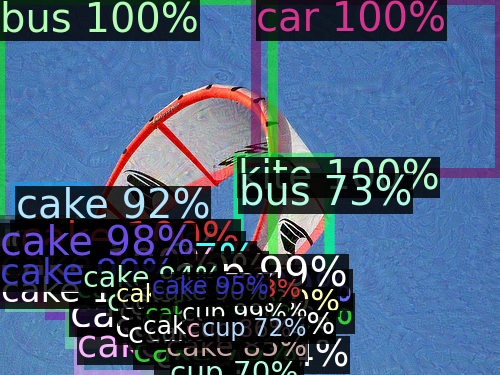

In [47]:
from google.colab.patches import cv2_imshow
cv2_imshow(display_adv_image_preds(model, input_attacked['image'], instance_mask_thresh=0.70))

In [ ]:
import cv2
zebra_image_path = image_path
display_benign_image_preds(model = model, cfg = cfg, image_path=zebra_image_path)

#Visualization

In [ ]:
batched_inputs = [input_benign] # change here
choice = 'unperturbed' # change here

with torch.no_grad():
    # https://github.com/facebookresearch/detectron2/blob/9853a337403ddde2ac270416536ee42341854ea1/detectron2/modeling/meta_arch/rcnn.py#L134
    images = model.preprocess_image(batched_inputs)
    features = model.backbone(images.tensor)
    p2 = features['p2']
    p3 = features['p3']
    p4 = features['p4']
    p5 = features['p5']
    p6 = features['p6']   
    obj_p2,ad_p2 = model.proposal_generator.rpn_head(p2[None,:])
    obj_p3,ad_p3 = model.proposal_generator.rpn_head(p3[None,:])
    obj_p4,ad_p4 = model.proposal_generator.rpn_head(p4[None,:])
    obj_p5,ad_p5 = model.proposal_generator.rpn_head(p5[None,:])
    obj_p6,ad_p6 = model.proposal_generator.rpn_head(p6[None,:])

    act2_max = torch.max(p2[0],0).values
    print("P2")
    plt.imshow(act2_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'P2_'+choice+'.png', act2_max.detach().cpu())
    act3_max = torch.max(p3[0],0).values
    print("P3")
    plt.imshow(act3_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'P3_'+choice+'.png', act3_max.detach().cpu())
    act4_max = torch.max(p4[0],0).values
    print("P4")
    plt.imshow(act4_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'P4_'+choice+'.png', act4_max.detach().cpu())
    act5_max = torch.max(p5[0],0).values
    print("P5")
    plt.imshow(act5_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'P5_'+choice+'.png', act5_max.detach().cpu())
    act6_max = torch.max(p6[0],0).values
    print("P6")
    plt.imshow(act6_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'P6_'+choice+'.png', act6_max.detach().cpu())
    act2_max = torch.max(obj_p2[0][0],0).values
    print("P2")
    plt.imshow(act2_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ObjP2_'+choice+'.png', act2_max.detach().cpu())
    act3_max = torch.max(obj_p3[0][0],0).values
    print("P3")
    plt.imshow(act3_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ObjP3_'+choice+'.png', act3_max.detach().cpu())
    act4_max = torch.max(obj_p4[0][0],0).values
    print("P4")
    plt.imshow(act4_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ObjP4_'+choice+'.png', act4_max.detach().cpu())
    act5_max = torch.max(obj_p5[0][0],0).values
    print("P5")
    plt.imshow(act5_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ObjP5_'+choice+'.png', act5_max.detach().cpu())
    act6_max = torch.max(obj_p6[0][0],0).values
    print("P6")
    plt.imshow(act6_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ObjP6_'+choice+'.png', act6_max.detach().cpu())
    act2_max = torch.max(ad_p2[0][0],0).values
    print("P2",act2_max.shape)
    plt.imshow(act2_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ADP2_'+choice+'.png', act2_max.detach().cpu())
    act3_max = torch.max(ad_p3[0][0],0).values
    print("P3")
    plt.imshow(act3_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ADP3_'+choice+'.png', act3_max.detach().cpu())
    act4_max = torch.max(ad_p4[0][0],0).values
    print("P4")
    plt.imshow(act4_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ADP4_'+choice+'.png', act4_max.detach().cpu())
    act5_max = torch.max(ad_p5[0][0],0).values
    print("P5")
    plt.imshow(act5_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ADP5_'+choice+'.png', act5_max.detach().cpu())
    act6_max = torch.max(ad_p6[0][0],0).values
    print("P6")
    plt.imshow(act6_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ADP6_'+choice+'.png', act6_max.detach().cpu())
  
batched_inputs = [input_attacked] # change here
choice = 'perturbed' # change here

with torch.no_grad():
    # https://github.com/facebookresearch/detectron2/blob/9853a337403ddde2ac270416536ee42341854ea1/detectron2/modeling/meta_arch/rcnn.py#L134
    images = model.preprocess_image(batched_inputs)
    features = model.backbone(images.tensor)
    p2 = features['p2']
    p3 = features['p3']
    p4 = features['p4']
    p5 = features['p5']
    p6 = features['p6']   
    obj_p2,ad_p2 = model.proposal_generator.rpn_head(p2[None,:])
    obj_p3,ad_p3 = model.proposal_generator.rpn_head(p3[None,:])
    obj_p4,ad_p4 = model.proposal_generator.rpn_head(p4[None,:])
    obj_p5,ad_p5 = model.proposal_generator.rpn_head(p5[None,:])
    obj_p6,ad_p6 = model.proposal_generator.rpn_head(p6[None,:])

    act2_max = torch.max(p2[0],0).values
    print("P2")
    plt.imshow(act2_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'P2_'+choice+'.png', act2_max.detach().cpu())
    act3_max = torch.max(p3[0],0).values
    print("P3")
    plt.imshow(act3_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'P3_'+choice+'.png', act3_max.detach().cpu())
    act4_max = torch.max(p4[0],0).values
    print("P4")
    plt.imshow(act4_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'P4_'+choice+'.png', act4_max.detach().cpu())
    act5_max = torch.max(p5[0],0).values
    print("P5")
    plt.imshow(act5_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'P5_'+choice+'.png', act5_max.detach().cpu())
    act6_max = torch.max(p6[0],0).values
    print("P6")
    plt.imshow(act6_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'P6_'+choice+'.png', act6_max.detach().cpu())
   
    act2_max = torch.max(obj_p2[0][0],0).values
    print("P2")
    plt.imshow(act2_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ObjP2_'+choice+'.png', act2_max.detach().cpu())
    act3_max = torch.max(obj_p3[0][0],0).values
    print("P3")
    plt.imshow(act3_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ObjP3_'+choice+'.png', act3_max.detach().cpu())
    act4_max = torch.max(obj_p4[0][0],0).values
    print("P4")
    plt.imshow(act4_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ObjP4_'+choice+'.png', act4_max.detach().cpu())
    act5_max = torch.max(obj_p5[0][0],0).values
    print("P5")
    plt.imshow(act5_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ObjP5_'+choice+'.png', act5_max.detach().cpu())
    act6_max = torch.max(obj_p6[0][0],0).values
    print("P6")
    plt.imshow(act6_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ObjP6_'+choice+'.png', act6_max.detach().cpu())
    act2_max = torch.max(ad_p2[0][0],0).values
    print("P2")
    plt.imshow(act2_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ADP2_'+choice+'.png', act2_max.detach().cpu())
    act3_max = torch.max(ad_p3[0][0],0).values
    print("P3")
    plt.imshow(act3_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ADP3_'+choice+'.png', act3_max.detach().cpu())
    act4_max = torch.max(ad_p4[0][0],0).values
    print("P4")
    plt.imshow(act4_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ADP4_'+choice+'.png', act4_max.detach().cpu())
    act5_max = torch.max(ad_p5[0][0],0).values
    print("P5")
    plt.imshow(act5_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ADP5_'+choice+'.png', act5_max.detach().cpu())
    act6_max = torch.max(ad_p6[0][0],0).values
    print("P6")
    plt.imshow(act6_max.cpu())
    plt.show()
    plt.imsave(name1+"_"+'ADP6_'+choice+'.png', act6_max.detach().cpu())
  

   
   

# Gradients and Gradcam


In [ ]:
from torch.autograd import Variable
a = Variable(input_attacked['image'], requires_grad = True)
height, width = a.shape[1:3]
inputs = {"image": a, "height": height, "width": width}
outputs = model([inputs])
score = sum(outputs[0]['instances'].scores)
print(score)
score.backward()
gradients = a.grad
gradients = torch.permute(gradients,(1,2,0)).detach().numpy()
gr = (gradients - np.min(gradients))/(np.max(gradients)-np.min(gradients))
cv2_imshow(gr*255)
gr1 = (gradients - np.mean(gradients))/np.std(gradients)
cv2_imshow(gr1*255)
plt.imsave(name1+'_Gradients_perturbed.png', arr=gr[:,:,::-1])

b = Variable(input_benign['image'].float(), requires_grad = True)
height, width = b.shape[1:3]
inputs = {"image": b, "height": height, "width": width}
outputs = model([inputs])
score = sum(outputs[0]['instances'].scores)
print(score)
score.backward()
gradients = b.grad
gradients = torch.permute(gradients,(1,2,0)).detach().numpy()
gr = (gradients - np.min(gradients))/(np.max(gradients)-np.min(gradients))
cv2_imshow(gr*255)
gr1 = (gradients - np.mean(gradients))/np.std(gradients)
cv2_imshow(gr1*255)
plt.imsave(name1+'_Gradients_unperturbed.png', arr=gr[:,:,::-1])


In [51]:
import cv2
import numpy as np

#### source: https://github.com/yizt/Grad-CAM.pytorch ####
class GradCAM(object):
    def __init__(self, net, layer_name):
        self.net = net
        self.layer_name = layer_name
        self.feature = None
        self.gradient = None
        self.net.eval()
        self.handlers = []
        self._register_hook()

    def _get_features_hook(self, module, input, output):
        self.feature = output
        print("feature shape:{}".format(output.size()))

    def _get_grads_hook(self, module, input_grad, output_grad):
        """
        :param input_grad: tuple, input_grad[0]: None
                                   input_grad[1]: weight
                                   input_grad[2]: bias
        :param output_grad:tuple
        :return:
        """
        self.gradient = output_grad[0]

    def _register_hook(self):
        for (name, module) in self.net.named_modules():
            if name == self.layer_name:
                self.handlers.append(module.register_forward_hook(self._get_features_hook))
                self.handlers.append(module.register_backward_hook(self._get_grads_hook))

    def remove_handlers(self):
        for handle in self.handlers:
            handle.remove()
    def calc_iou(self,boxA, boxB):
      # determine the (x, y)-coordinates of the intersection rectangle
      xA = max(boxA[0], boxB[0])
      yA = max(boxA[1], boxB[1])
      xB = min(boxA[2], boxB[2])
      yB = min(boxA[3], boxB[3])

      # compute the area of intersection rectangle
      interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
      if interArea == 0:
          return 0
      # compute the area of both the prediction and ground-truth
      # rectangles
      boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
      boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

      # compute the intersection over union by taking the intersection
      # area and dividing it by the sum of prediction + ground-truth
      # areas - the interesection area
      iou = interArea / float(boxAArea + boxBArea - interArea)

      # return the intersection over union value
      return iou

    def __call__(self, inputs, index=0):
        """
        :param inputs: {"image": [C,H,W], "height": height, "width": width}
        :param index:
        :return:
        """
        self.net.zero_grad()
        output = self.net.inference([inputs])
        print("o",output)
        score = output[0]['instances'].scores[index]
        score.backward()
        gradient = self.gradient.cpu().data.numpy()  # [C,H,W]
        gradient = gradient[0]
         weight = np.mean(gradient, axis=(1, 2))  # [C]
        # print("c",weight.shape)

        feature = self.feature.cpu().data.numpy()[0]  # [C,H,W]
        # print("c,h,w",feature.shape)

        cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        # print("c,h,w",cam.shape)
        cam = np.sum(cam, axis=0)  # [H,W]
        # print("h,w",cam.shape)
        cam = np.maximum(cam, 0)  # ReLU
        # print("gcdone")

  
        cam -= np.min(cam)
        cam /= np.max(cam)
        # resize to 224*224
        box = output[0]['instances'].pred_boxes.tensor[index].cpu().detach().numpy().astype(np.int32)
        x1, y1, x2, y2 = box
        cam = cv2.resize(cam, (x2 - x1, y2 - y1))

        class_id = output[0]['instances'].pred_classes[index].cpu().detach().numpy()
        return cam, box, class_id


class GradCamPlusPlus(GradCAM):
    def __init__(self, net, layer_name):
        super(GradCamPlusPlus, self).__init__(net, layer_name)

    def calc_iou(self,boxA, boxB):
      # determine the (x, y)-coordinates of the intersection rectangle
      xA = max(boxA[0], boxB[0])
      yA = max(boxA[1], boxB[1])
      xB = min(boxA[2], boxB[2])
      yB = min(boxA[3], boxB[3])

      # compute the area of intersection rectangle
      interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
      if interArea == 0:
          return 0
      # compute the area of both the prediction and ground-truth
      # rectangles
      boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
      boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

      # compute the intersection over union by taking the intersection
      # area and dividing it by the sum of prediction + ground-truth
      # areas - the interesection area
      iou = interArea / float(boxAArea + boxBArea - interArea)

      # return the intersection over union value
      return iou

    def __call__(self, inputs, index=0):

        self.net.zero_grad()
        output = self.net.inference([inputs])
        score = output[0]['instances'].scores[index]
        score.backward()
        gradient = self.gradient[0].cpu().data.numpy()  # [C,H,W]
        print("gg",gradient.shape)
        gradient = np.maximum(gradient, 0.)  # ReLU
        indicate = np.where(gradient > 0, 1., 0.) 
        norm_factor = np.sum(gradient, axis=(1, 2))  
        for i in range(len(norm_factor)):
            norm_factor[i] = 1. / norm_factor[i] if norm_factor[i] > 0. else 0.  
        alpha = indicate * norm_factor[:, np.newaxis, np.newaxis]  # [C,H,W]
        weight = np.sum(gradient * alpha, axis=(1, 2))  # [C]  alpha*ReLU(gradient)
        feature = self.feature.cpu().data.numpy()[0]  # [C,H,W]
        cam = feature * weight[:, np.newaxis, np.newaxis]  # [C,H,W]
        cam = np.sum(cam, axis=0)  # [H,W]
        cam -= np.min(cam)
        cam /= np.max(cam)
        print("o1",output)
        box = output[0]['instances'].pred_boxes.tensor[index].cpu().detach().numpy().astype(np.int32)
        cam = cv2.resize(cam, (inputs['width'],inputs['height']))

        return cam

import torch, torchvision

# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse
import multiprocessing as mp
import os
import detectron2
import cv2
import detectron2.data.transforms as T
import numpy as np
import torch
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.data.detection_utils import read_image
from detectron2.modeling import build_model
from detectron2.utils.logger import setup_logger
#from grad_cam import GradCAM, GradCamPlusPlus
from skimage import io
from torch import nn

# constants
WINDOW_NAME = "COCO detections"


def setup_cfg(args):
    # load config from file and command-line arguments
    cfg = get_cfg()
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = args.confidence_threshold
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = args.confidence_threshold
    cfg.freeze()
    return cfg


def get_last_conv_name(net):

    layer_name = None
    for name, m in net.named_modules():
        if isinstance(m, nn.Conv2d) and name == 'backbone.bottom_up.res5.2.conv3':
            layer_name = name
    return layer_name


def norm_image(image):
    image = image.copy()
    image -= np.max(np.min(image), 0)
    image /= np.max(image)
    image *= 255.
    return np.uint8(image)


def gen_cam(image, mask):
    heatmap = cv2.applyColorMap((255 * mask).astype(np.uint8), cv2.COLORMAP_JET)
    print("after applycolourmap")
    cv2_imshow(heatmap)
    heatmap = np.float32(heatmap) / 255
    heatmap = heatmap[..., ::-1]  # gbr to rgb
    return 1, heatmap



def save_image(image_dicts, input_image_name, network='frcnn', output_dir='./results'):
    prefix = os.path.splitext(input_image_name)[0]
    for key, image in image_dicts.items():
        io.imsave(os.path.join(output_dir, '{}-{}-{}.jpg'.format(prefix, network, key)), image)


from detectron2 import model_zoo

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
model = build_model(cfg)
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)
model.eval()

In [ ]:
#choose your visualization technique using GradCam or GradCamPlusPlus 
layer_name = get_last_conv_name(model)
grad_cam_plus_plus = GradCamPlusPlus(model, layer_name) # or Gradcam and save accordingly
mask_plus_plus = grad_cam_plus_plus(input_benign)
state = 'unperturbed'
heatmap = cv2.applyColorMap((255 * mask_plus_plus).astype(np.uint8), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
heatmap = heatmap[..., ::-1] 
print(heatmap.shape)
plt.imshow(heatmap)
img = plt.imshow(heatmap)
plt.axis('off')
plt.savefig(name1+'_Gradcam_'+state+'.png', bbox_inches='tight') #Or Gradcam save accordingly

grad_cam_plus_plus = GradCamPlusPlus(model, layer_name) # or Gradcam and save accordingly
mask_plus_plus = grad_cam_plus_plus(input_attacked)
state = 'perturbed'
heatmap = cv2.applyColorMap((255 * mask_plus_plus).astype(np.uint8), cv2.COLORMAP_JET)
heatmap = np.float32(heatmap) / 255
heatmap = heatmap[..., ::-1]  
plt.imshow(heatmap)

img = plt.imshow(heatmap)
plt.axis('off')
plt.savefig(name1+'_Gradcam_'+state+'.png', bbox_inches='tight') #Or Gradcam save accordingly

In [ ]:
!zip -r /content/file.zip /content/

In [55]:
from google.colab import files
files.download("/content/file.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>